# Overview

Goal: Create a new, less basic profile picture for my GitHub account.

Method: Utilizes tensorflow eager execution

Style Image: "Les Feuilles Mortes" by my favorite surrealist artist, Remedios Varo.

Reference: Code references the codebase found in the article "Neural Style Transfer: Creating Art With Deep Learning using tf keras and eager execution." More information about this reference can be found in the ReadMe.

# Imports

In [14]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
#from PIL import Image

import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

import time

# Used to stop the kernal from dying
### HOWEVER ###
# Is dangerous, nervous to increase iterations to above 10 for fear of killing the kernal
# Need to look into alternative methods for running
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Constants

In [30]:
ORIGINAL_IMG_PATH = "Images/original-profile-image.jpeg"
STYLE_IMG_PATH = "Images/style-image.jpeg"

# Content layer where will pull our feature maps
CONTENT_LAYERS = ['block5_conv2'] 

# Style layer we are interested in
STYLE_LAYERS = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

NUM_CONTENT_LAYERS = len(CONTENT_LAYERS)
NUM_STYLE_LAYERS = len(style_layers)

# Exploration

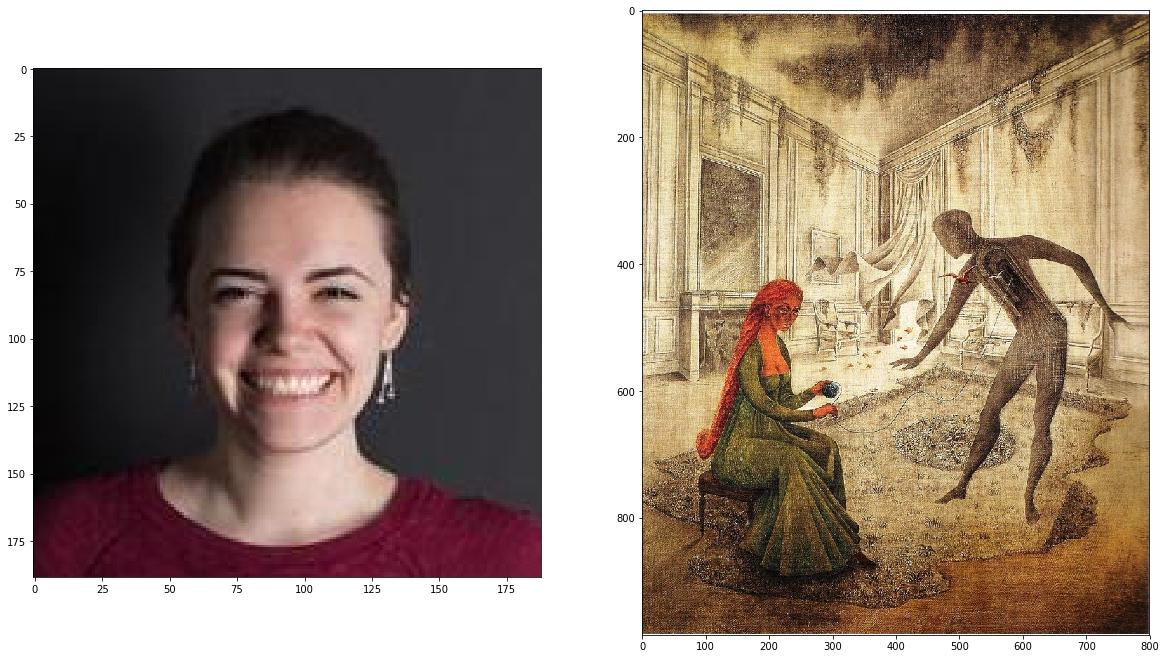

In [6]:
# Show the images that will be used
plt.figure(figsize=(20,20))

content = mpimg.imread(ORIGINAL_IMG_PATH)
style = mpimg.imread(STYLE_IMG_PATH)

plt.subplot(1, 2, 1)
plt.imshow(content)

plt.subplot(1, 2, 2)
plt.imshow(style)
plt.show()

# Initialize TensorFlow

In [7]:
# Enable and test TensorFlow eager execution
# This lightens the load as we are using a pre-trained CNN and do not require a graph
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


# Image Functions

In [32]:
def load_and_process_img(path_to_img):
    img = mpimg.imread(path_to_img)
    img = np.expand_dims(img, axis=0) # TODO Why required?
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img


def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")

    # perform the inverse of the preprocessiing step
    # TODO Either pull out these numbers into constants or find a reason why they're here
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Creating Model Functions

In [31]:
def get_model():
    """ Creates our model with access to intermediate layers. 

    This function will load the VGG19 model and access the intermediate layers. 
    These layers will then be used to create a new model that will take input image
    and return the outputs from these intermediate layers from the VGG model. 

    Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 
    """
    # Load our model. We load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    # Get output layers corresponding to style and content layers 
    style_outputs = [vgg.get_layer(name).output for name in STYLE_LAYERS]
    content_outputs = [vgg.get_layer(name).output for name in CONTENT_LAYERS]
    model_outputs = style_outputs + content_outputs
    # Build model 
    return models.Model(vgg.input, model_outputs)

def get_feature_representations(model, content_path, style_path):
    """Helper function to compute our content and style feature representations.

    This function will simply load and preprocess both the content and style 
    images from their path. Then it will feed them through the network to obtain
    the outputs of the intermediate layers. 

    Arguments:
    model: The model that we are using.
    content_path: The path to the content image.
    style_path: The path to the style image

    Returns:
    returns the style features and the content features. 
    """
    # Load our images in 
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)

    # batch compute content and style features
    style_outputs = model(style_image)
    content_outputs = model(content_image)


    # Get the style and content feature representations from our model  
    style_features = [style_layer[0] for style_layer in style_outputs[:len(NUM_STYLE_LAYERS)]]
    content_features = [content_layer[0] for content_layer in content_outputs[NUM_STYLE_LAYERS:]]
    return style_features, content_features

def gram_matrix(input_tensor):
    # We make the image channels first 
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

# TODO
# This function needs to be broken out into smaller, more easily digestible functions
def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
    
    global_start = time.time()
    
    # We don't need to (or want to) train any layers of our model, so we set their
    # trainable to false. 
    model = get_model() 
    for layer in model.layers:
        layer.trainable = False

    # Get the style and content feature representations (from our specified intermediate layers) 
    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    # Set initial image
    init_image = load_and_process_img(content_path)
    init_image = tfe.Variable(init_image, dtype=tf.float32)
    
    # Create our optimizer
    # TODO Where do these values come from?
    # Should they be pulled out as parameters for the function?
    opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

    # For displaying intermediate images 
    # TODO Why?
    iter_count = 1

    # Store our best result
    best_loss, best_img = float('inf'), None
    
    # TODO
    # Pull out this dictionary, it should be an object instead
    cfg = {
      'model': model,
      'loss_weights': (style_weight, content_weight),
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
    }

    # TODO
    # Where do these numbers come from?
    # If required, should be pulled out as constants
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   

    imgs = []
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped) 
        current_image = deprocess_img(init_image.numpy())
        
        # Add processed image into the list of all processed images
        imgs.append(current_image)

        if loss < best_loss:
            # Update best loss and best image from total loss. 
            best_loss = loss
            best_img = current_image
            print('Iteration: {}'.format(i))
            print('Total loss: {:.4e}, ' 
                'style loss: {:.4e}, '
                'content loss: {:.4e}, ')
            
    print('Total time: {:.4f}s'.format(time.time() - global_start))
    return best_img, imgs, best_loss 

# Metric Functions

In [33]:
# TODO
# Need to dig in and see the purpose of a lot of these metrics. Is performing this math ourselves required?
# How can we clean up this code so as to be more efficient and readable?

def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(**cfg)
    # Compute gradients wrt input image
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))


def get_style_loss(base_style, gram_target):
    """Expects two images of dimension h, w, c"""
    # height, width, num filters of each layer
    # We scale the loss at a given layer by the size of the feature map and the number of filters
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)

    return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    """This function will compute the loss total loss.

    Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function. 
      (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with 
      our optimization process. We apply the gradients wrt the loss we are 
      calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the 
      defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of 
      interest.

    Returns:
    returns the total loss, style loss, content loss, and total variational loss
    """
    style_weight, content_weight = loss_weights

    # Feed our init image through our model. This will give us the content and 
    # style representations at our desired layers. Since we're using eager
    # our model is callable just like any other function!
    model_outputs = model(init_image)

    style_output_features = model_outputs[:NUM_STYLE_LAYERS]
    content_output_features = model_outputs[NUM_STYLE_LAYERS:]

    style_score = 0
    content_score = 0

    # Accumulate style losses from all layers
    # Here, we equally weight each contribution of each loss layer
    weight_per_style_layer = 1.0 / float(NUM_STYLE_LAYERS)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

    # Accumulate content losses from all layers 
    weight_per_content_layer = 1.0 / float(NUM_CONTENT_LAYERS)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)

    style_score *= style_weight
    content_score *= content_weight

    # Get total loss
    loss = style_score + content_score 
    return loss, style_score, content_score

# Visualization Functions

In [36]:
# Shows only the best image, compared to the originals
def show_best_results(best_img, content_path, style_path, show_large_final=True):
    plt.figure(figsize=(10, 5))
    content = mpimg.imread(content_path) 
    style = mpimg.imread(style_path)

    plt.subplot(1, 2, 1)
    plt.imshow(content)

    plt.subplot(1, 2, 2)
    plt.imshow(style)

    if show_large_final: 
        plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

# Shows all images that were generated
def show_all_results(all_images):
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations/(num_rows*num_cols)

    for i,img in enumerate(all_images):
        plt.subplot(num_rows,num_cols,i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.show()

# Get Results

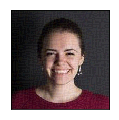

In [15]:
best, all_images, best_loss = run_style_transfer(ORIGINAL_IMG_PATH, 
                                     STYLE_IMG_PATH, num_iterations=6)

# Visualize Results

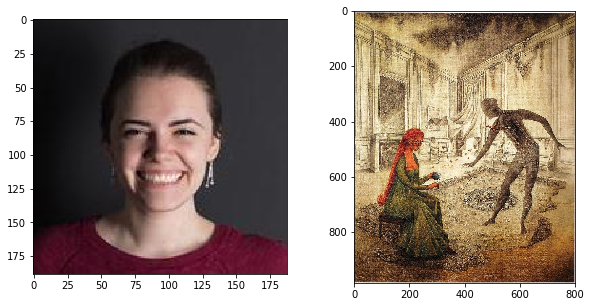

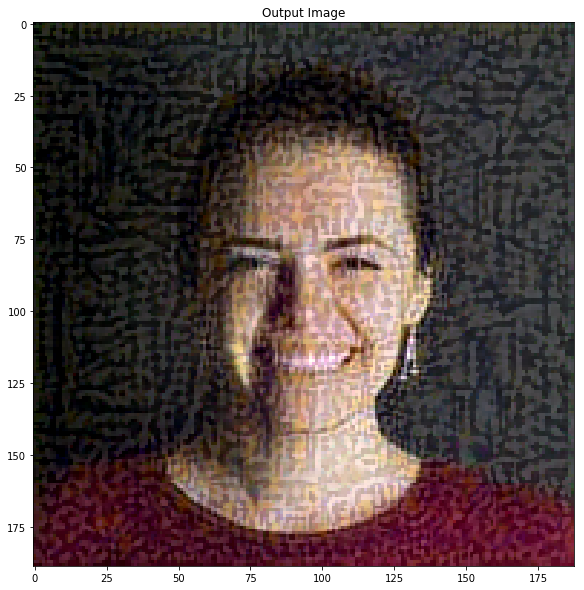

In [28]:
show_results(best, ORIGINAL_IMG_PATH, STYLE_IMG_PATH)

# Inital Thoughts

Pretty ugly.

Definitly needs to run for greater than 6 iterations. But since a single iteration takes about 4 minutes running on CPU, I'm not going to risk rewriting my hard drive for it... again.

Need to research an alternative run method, perhaps cloud base. But that will also require exploring funding.